In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.optimize import curve_fit

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
d_file = 'inclination_results.npz'

In [4]:
b = np.load(d_file)

In [5]:
b.files

['crit_inc',
 'all_labels',
 'all_inclinations_err_minus',
 'good_mask',
 'all_inclinations_err_plus',
 'all_jd',
 'jd_offset',
 'all_inclinations',
 'all_jd_err']

In [6]:
b['crit_inc']

array(1.24443358)

In [7]:
b['jd_offset']

array(2440000.)

In [8]:
years = Time(b['all_jd'] + b['jd_offset'], format='jd').to_value('decimalyear')
incl = np.rad2deg(b['all_inclinations'])
ierr = np.rad2deg(b['all_inclinations_err_plus'])

# add extra error for first 2 epochs...
ierr[0:2] = ierr[0:2] * 3.

In [9]:
# add approx datapoint from Strohmeier+1965 (as reported by Zasche+2012, Tbl1)
years = np.append(years, 1964.)
incl = np.append(incl, 88.9)
ierr = np.append(ierr, 1.1)

Text(0, 0.5, 'incl (deg)')

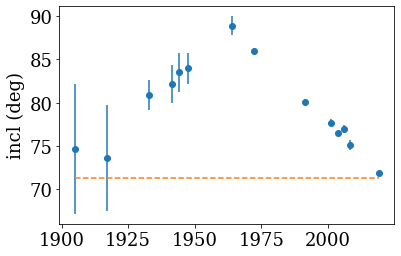

In [10]:
plt.errorbar(years, incl, yerr=ierr,
             linestyle='none', marker='o')
plt.plot([years.min(),years.max()], [np.rad2deg(b['crit_inc']), np.rad2deg(b['crit_inc'])], linestyle='--')
plt.ylabel('incl (deg)')

In [11]:
# OK, let's read papers and try to fit the nodal period!

In [12]:
# here is the eqn being used to model nodal period in 3body system
def Pmodel(t, c1, c2, t0, Pnodal):
    # c1 == cos(I) x cos(i_1)
    # c2 == sin(I) x sin(i_1)
    cosi = c1 - c2*np.cos(2*np.pi * (t - t0) / Pnodal)
    return cosi

[0.02, 0.6, 2434.25, 631.0]


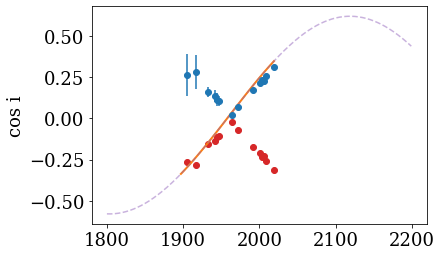

In [13]:
cosi = np.cos(np.deg2rad(incl))
cosi_err = np.abs(np.sin(np.deg2rad(incl)) * np.deg2rad(ierr))
plt.errorbar(years, cosi, yerr=cosi_err,
            linestyle='none', marker='o')
plt.ylabel('cos i')
plt.scatter(years, -np.cos(np.deg2rad(incl)), c='C3')

tt = np.arange(1897, 2020)
# just make up some values to guess & draw a curve, but we know it's ~631yrs
# p0 = [2.3, 2.3, 1961., 631.]
p0 = [.02, .6, 1961 + (631.*0.75), 631.]
print(p0)
plt.plot(tt, Pmodel(tt, *p0), lw=2) 
tfuture = np.arange(1800,2200)
plt.plot(tfuture, Pmodel(tfuture, *p0), c='C4', linestyle='--', alpha=0.5) 

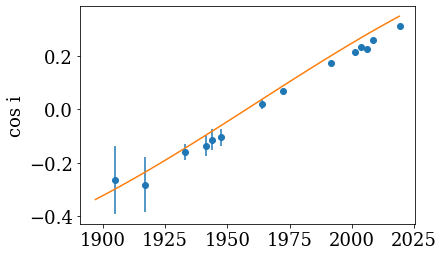

In [14]:
neg = np.where((years < 1961))[0]
cosi[neg] = -1*cosi[neg]

plt.errorbar(years, cosi, yerr=cosi_err,
            linestyle='none', marker='o')
plt.ylabel('cos i')

plt.plot(tt, Pmodel(tt, *p0)) 

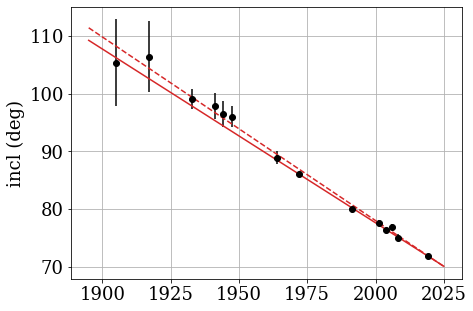

In [15]:
# the simple linear inclination change model - a system slowly tumbling 

plt.figure(figsize=(7,5))
plt.errorbar(years, np.rad2deg(np.arccos(cosi)), yerr=ierr, marker='o', linestyle='none', c='k')

ff0 = np.polyfit(years, np.rad2deg(np.arccos(cosi)), 1)
ff = np.polyfit(years, np.rad2deg(np.arccos(cosi)), 1, w=1/ierr,)

yrs = np.arange(1895, 2026)
plt.plot(yrs, np.polyval(ff, yrs),c='C3')
plt.plot(yrs, np.polyval(ff0, yrs),c='C3', linestyle='--')


# plt.plot([years.min(),years.max()], [np.rad2deg(b['crit_inc']), np.rad2deg(b['crit_inc'])], linestyle='--')
# plt.plot([years.min(),years.max()], [90+(90-np.rad2deg(b['crit_inc'])), 90+(90-np.rad2deg(b['crit_inc']))], linestyle='--')

plt.ylabel('incl (deg)')

plt.grid(True)
# plt.savefig('approx_incl_LS.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)


In [16]:
print(ff[0], 'deg / yr') # the slope in deg per year
print(np.abs(360/ff[0]), 'yrs to tumble 360deg') # the number of years to do a full tumble (360deg)

print((90+(90-np.rad2deg(b['crit_inc'])) - ff[1]) / ff[0], 'start') # when did the eclipses likely start?
print((np.rad2deg(b['crit_inc']) - ff[1]) / ff[0], 'end') # when do the eclipses likely end?

# approx when will it eclipse again? (half a tumble cycle)
print(((90-np.rad2deg(b['crit_inc'])) - ff[1])/ff[0], 'start again')

-0.3007324584428455 deg / yr
1197.077302077848 yrs to tumble 360deg
1896.7422241134846 start
2021.0999869508073 end
2196.0115496329463 start again


In [17]:
Time((np.rad2deg(b['crit_inc']) - ff[1]) / ff[0], format='decimalyear').to_value('fits')

'2021-02-06T11:53:08.481'

In [18]:
fit, cov = curve_fit(Pmodel, years, cosi, sigma=cosi_err, p0=p0,
                     maxfev=10000, bounds = ([-0.1, -1, 1000, 400], [0.1, 1, 3000, 1800]))

print(fit)
print(np.sqrt(np.diag(cov)))

print(fit[3], np.sqrt(np.diag(cov))[3]) # the nodal period from this... "fit"

# plt.errorbar(years, cosi, yerr=cosi_err,
#             linestyle='none', marker='o')
# plt.plot(tt, Pmodel(tt, *fit), c='C3') 
# plt.ylabel('cos i');

[-1.00000000e-01  8.46827830e-01  2.67111764e+03  9.73555671e+02]
[8.32163232e-01 1.47176631e+00 1.02593933e+03 1.56284378e+03]
973.555670599204 1562.8437779463736


Text(0, 0.5, 'cos i')

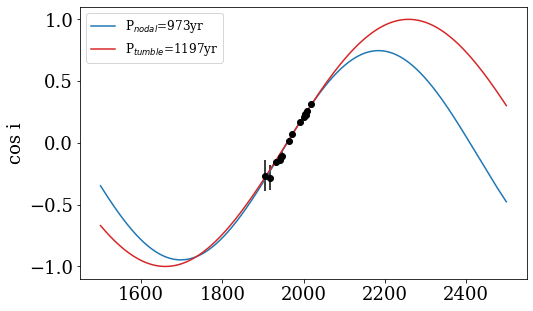

In [19]:
tfuture = np.arange(1500,2500)
plt.figure(figsize=(8,5))
plt.errorbar(years, cosi, yerr=cosi_err,
            linestyle='none', marker='o', color='k')

# plt.plot(tfuture, Pmodel(tfuture, *p0), c='C1', alpha=0.5, label='init, P$_{nodal}$=631yr') 
plt.plot(tfuture, Pmodel(tfuture, *fit), c='C0', label='P$_{nodal}$='+str(int(fit[3]))+'yr') 
plt.plot(tfuture, np.cos(np.deg2rad(np.polyval(ff, tfuture))), c='C3', 
         label='P$_{tumble}$='+str(int(np.abs(360/ff[0])))+'yr')
plt.legend(fontsize=12)
plt.ylabel('cos i')


In [20]:
# MLE
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(1983)
nll = lambda *args: -log_likelihood(*args)
initial = np.array(np.append(ff, -2.)) + 0.01 * np.random.randn(3)
soln = minimize(nll, initial, args=(years, np.rad2deg(np.arccos(cosi)), ierr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
m = -0.301
b = 680.460
f = 0.000


In [21]:
# try fitting straight line w/ MCMC
# https://emcee.readthedocs.io/en/stable/tutorials/line/

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0 and 0.0 < b < 1000 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [22]:
soln.x

array([-3.01416005e-01,  6.80460085e+02, -1.51812957e+01])

In [24]:
import emcee

# add extra dimension for additional variance, per emcee docs
pos = np.append(ff, 0.) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(years[2:], np.rad2deg(np.arccos(cosi))[2:], ierr[2:]))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:07<00:00, 1336.98it/s]


In [26]:
tau = sampler.get_autocorr_time()
print(tau)

[ 80.29058331  81.78353488 108.18561339]


In [27]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(19200, 3)


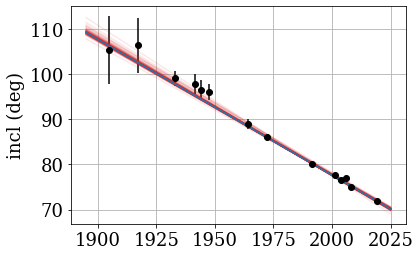

In [28]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(yrs, np.dot(np.vander(yrs, 2), sample[:2]), "C3", alpha=0.1)

plt.errorbar(years, np.rad2deg(np.arccos(cosi)), yerr=ierr, fmt="ok", capsize=0)
plt.plot(yrs, np.polyval(ff, yrs),c='C0')
plt.ylabel('incl (deg)')

plt.grid(True)


In [29]:
def therng(thething, rng=[15,50,84]):
    pcent = np.percentile(thething, rng)
    q = np.diff(pcent)
    return pcent[1], q[0], q[1]

print(therng(flat_samples[:,0]), 'deg / yr') # the slope in deg per year
# the number of years to do a full tumble (360deg)
print(therng(np.abs(360/flat_samples[:,0])), 'yrs to tumble 360deg') 

# when did the eclipses likely start?
print(therng((90+(90-np.rad2deg(b['crit_inc'])) - flat_samples[:,1]) / flat_samples[:,0]), 'start') 
# when do the eclipses likely end?
print(therng((np.rad2deg(b['crit_inc']) - flat_samples[:,1]) / flat_samples[:,0]), 'end') 

# approx when will it eclipse again? (half a tumble cycle)
print(therng(((90-np.rad2deg(b['crit_inc'])) - flat_samples[:,1])/flat_samples[:,0]), 'start again')

(-0.30116321840586313, 0.004623380539759914, 0.0035312040324206873) deg / yr
(1195.3650977229836, 18.073479126555867, 14.182204363785559) yrs to tumble 360deg
(1896.9026021423101, 1.0181434503883793, 1.3401920331250494) start
(2021.121026874073, 0.5401016368634828, 0.5336726473549334) end
(2195.76712398526, 3.1571620831809923, 2.570730618987909) start again


In [30]:
ff

array([-3.00732458e-01,  6.79111160e+02])

In [31]:
soln.x

array([-3.01416005e-01,  6.80460085e+02, -1.51812957e+01])

In [32]:
np.median(flat_samples, axis=0)

array([-3.01163218e-01,  6.79985762e+02, -7.69975199e+00])

In [33]:
chisq_mcmc = np.zeros(len(flat_samples[:,0]))
for k in range(len(flat_samples[:,0])):
    chisq_mcmc[k] = np.sum(((np.rad2deg(np.arccos(cosi)) - (years * flat_samples[k,0] + flat_samples[k,1])) / ierr) **2) / incl.size

min(chisq_mcmc)

0.937959102387432

In [34]:
best = np.argmin(chisq_mcmc)
flat_samples[best,:]

array([-3.00774106e-01,  6.79193433e+02, -9.97473996e+00])

In [35]:
np.sum(((np.rad2deg(np.arccos(cosi)) - (years * ff[0] + ff[1])) / ierr) **2) / incl.size


0.937941627638536

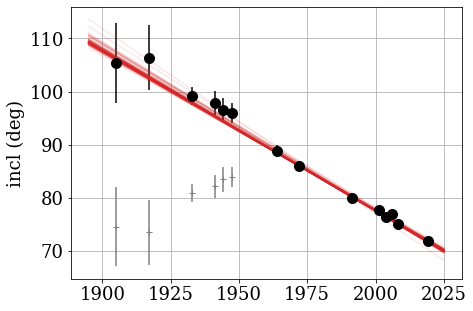

In [36]:
plt.figure(figsize=(7,5))
plt.errorbar(years, incl, yerr=ierr, marker='+', linestyle='none',  c='grey')
plt.errorbar(years, np.rad2deg(np.arccos(cosi)), yerr=ierr, fmt="ok", capsize=0, markersize=10)

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(yrs, np.dot(np.vander(yrs, 2), sample[:2]), "C3", alpha=0.1)

plt.ylabel('incl (deg)')

plt.grid(True)
# plt.savefig('mcmc_incl.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
# plt.savefig('fig5.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [39]:
incl

array([74.64685773, 73.6089842 , 80.8866007 , 82.18477826, 83.49697847,
       83.98558644, 86.01643353, 80.08034502, 77.6967624 , 76.45718091,
       76.95493623, 75.09996977, 71.8626054 , 88.9       ])

In [41]:
# Data behind Figure (DbF) dump for AAS Journals

df_out = pd.DataFrame(data={'year':years,
                            'i':incl,
                            'i_err':ierr
                           })
df_out.to_csv('fig5_data.csv',index=False)

In [35]:
years

array([1904.94091894, 1916.97932755, 1932.93737523, 1941.41312124,
       1943.99290586, 1947.44868927, 1972.16494434, 1991.55880986,
       2001.11837748, 2003.78460537, 2005.94881192, 2008.24635954,
       2019.19398799, 1964.        ])